In [6]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
from datetime import datetime
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

### Loading Price Data

In [7]:
project_root = os.path.abspath(os.getcwd())

data_dir = os.path.join(project_root, '..', '..', 'data')

# Summer month

p_summer = pd.read_csv(os.path.join(data_dir, 'Spotmarket_August_Corrected.csv'),sep=',')
#change price from euro/mwh to euro/kwh and renaming the column
p_summer['price_EUR_MWh'] = p_summer['price_EUR_MWh'] / 1000
p_summer.rename(columns={'price_EUR_MWh': 'Spotmarket_(EUR/kWh)'}, inplace=True)

# Winter month

p_winter = pd.read_csv(os.path.join(data_dir, 'Spotmarket_December_Corrected.csv'),sep=',')
#change price from euro/mwh to euro/kwh and renaming the column
p_winter['price_EUR_MWh'] = p_winter['price_EUR_MWh'] / 1000
p_winter.rename(columns={'price_EUR_MWh': 'Spotmarket_(EUR/kWh)'}, inplace=True)

#Spotmarket data from: https://energy-charts.info/charts/price_spot_market/chart.htm?l=en&c=CH&interval=month&year=2024&legendItems=by4&month=12

### Loading Fixed Appliances Data

In [8]:
#TV consumption data for summer month
tv_summer = pd.read_csv(os.path.join(data_dir, 'tv_consumption_august_2024_detailed.csv'), sep=',')

#TV consumption data for winter month
tv_winter = pd.read_csv(os.path.join(data_dir, 'tv_consumption_december_2024_detailed.csv'), sep=',')

#Lighting consumption data for summer month
lighting_summer = pd.read_csv(os.path.join(data_dir, 'lighting_consumption_august_2024.csv'), sep=',')

#Lighting consumption data for winter month
lighting_winter = pd.read_csv(os.path.join(data_dir, 'lighting_consumption_december_2024.csv'), sep=',')

#Fridge consumption data for summer month
fridge_summer = pd.read_csv(os.path.join(data_dir, 'fridge_August_Final_Adjusted.csv'), sep=',')

#Fridge consumption data for winter month
fridge_winter = pd.read_csv(os.path.join(data_dir, 'fridge_December_Final_Adjusted.csv'), sep=',')

#Oven consumption data for summer month
oven_summer = pd.read_csv(os.path.join(data_dir, 'Oven_Energy_Consumption_August_Final.csv'),sep=',')

#Oven consumption data for winter month
oven_winter = pd.read_csv(os.path.join(data_dir, 'Oven_Energy_Consumption_December_Final.csv'),sep=',')

#Induction stove consumption data for summer month
induction_summer = pd.read_csv(os.path.join(data_dir, 'Induction_Stove_Energy_Consumption_August_Final.csv'),sep=',')

#Induction stove consumption data for winter month
induction_winter = pd.read_csv(os.path.join(data_dir, 'Induction_Stove_Energy_Consumption_December_Final.csv'),sep=',')

#adjust names of columns for summer
tv_summer.columns = tv_summer.columns.str.replace('tv_power_kWh', 'TV_Consumption_(kWh)')
lighting_summer.columns = lighting_summer.columns.str.replace('lighting_power_kWh', 'Lighting_Consumption_(kWh)')
fridge_summer.columns = fridge_summer.columns.str.replace('consumption_kWh', 'Fridges_Consumption_(kWh)')
oven_summer.columns = oven_summer.columns.str.replace('consumption_kWh', 'Oven_Consumption_(kWh)')
induction_summer.columns = induction_summer.columns.str.replace('consumption_kWh', 'Induction_Stove_Consumption_(kWh)')




#adjust names of columns for winter
tv_winter.columns = tv_winter.columns.str.replace('tv_power_kWh', 'TV_Consumption_(kWh)')
lighting_winter.columns = lighting_winter.columns.str.replace('lighting_power_kWh', 'Lighting_Consumption_(kWh)')
fridge_winter.columns = fridge_winter.columns.str.replace('consumption_kWh', 'Fridges_Consumption_(kWh)')
oven_winter.columns = oven_winter.columns.str.replace('consumption_kWh', 'Oven_Consumption_(kWh)')
induction_winter.columns = induction_winter.columns.str.replace('consumption_kWh', 'Induction_Stove_Consumption_(kWh)')

### Load PV Data

In [9]:
#PV data for summer month
pv_summer_total = pd.read_csv(os.path.join(data_dir, 'pv_august.csv'), sep=',')
pv_summer_total['PV_energy_production_kWh'] = pv_summer_total['PV_energy_production_kWh']

#PV data for winter month
pv_winter_total = pd.read_csv(os.path.join(data_dir, 'pv_december.csv'), sep=',')
pv_winter_total['PV_energy_production_kWh'] = pv_winter_total['PV_energy_production_kWh']

#extract the timestamp and the Energy_production columns $
pv_summer = pv_summer_total[['timestamp', 'PV_energy_production_kWh']]
pv_winter = pv_winter_total[['timestamp', 'PV_energy_production_kWh']]

#print(p_summer)

### Building Database

In [10]:
# Ensure all timestamp columns are of the same type for summer
p_summer['timestamp'] = pd.to_datetime(p_summer['timestamp'])
lighting_summer['timestamp'] = pd.to_datetime(lighting_summer['timestamp'])
fridge_summer['timestamp'] = pd.to_datetime(fridge_summer['timestamp'])
oven_summer['timestamp'] = pd.to_datetime(oven_summer['timestamp'])
induction_summer['timestamp'] = pd.to_datetime(induction_summer['timestamp'])
tv_summer['timestamp'] = pd.to_datetime(tv_summer['timestamp'])
pv_summer['timestamp'] = pd.to_datetime(pv_summer['timestamp'], format='%Y-%m-%d %H:%M:%S') #-> already done in the previous step

# Ensure all timestamp columns are of the same type for winter
p_winter['timestamp'] = pd.to_datetime(p_winter['timestamp'])
lighting_winter['timestamp'] = pd.to_datetime(lighting_winter['timestamp'])
fridge_winter['timestamp'] = pd.to_datetime(fridge_winter['timestamp'])
oven_winter['timestamp'] = pd.to_datetime(oven_winter['timestamp'])
induction_winter['timestamp'] = pd.to_datetime(induction_winter['timestamp'])
tv_winter['timestamp'] = pd.to_datetime(tv_winter['timestamp'])
pv_winter['timestamp'] = pd.to_datetime(pv_winter['timestamp'], format='%Y-%m-%d %H:%M:%S') #-> already done in the previous step

#change year from 2024 to 2023 for summer data in timestamp
tv_summer['timestamp'] = tv_summer['timestamp'].apply(lambda x: x.replace(year=2023))
lighting_summer['timestamp'] = lighting_summer['timestamp'].apply(lambda x: x.replace(year=2023))
fridge_summer['timestamp'] = fridge_summer['timestamp'].apply(lambda x: x.replace(year=2023))
oven_summer['timestamp'] = oven_summer['timestamp'].apply(lambda x: x.replace(year=2023))
induction_summer['timestamp'] = induction_summer['timestamp'].apply(lambda x: x.replace(year=2023))
#change year from 2024 to 2023 for winter data
tv_winter['timestamp'] = tv_winter['timestamp'].apply(lambda x: x.replace(year=2023))
lighting_winter['timestamp'] = lighting_winter['timestamp'].apply(lambda x: x.replace(year=2023))
fridge_winter['timestamp'] = fridge_winter['timestamp'].apply(lambda x: x.replace(year=2023))
oven_winter['timestamp'] = oven_winter['timestamp'].apply(lambda x: x.replace(year=2023))
induction_winter['timestamp'] = induction_winter['timestamp'].apply(lambda x: x.replace(year=2023))


#shorten the dataset to 4 weeks (4 weeks * 7 days * 24 hours = 672 rows) for summer
lighting_summer = lighting_summer.iloc[:4 * 7 * 24]
fridge_summer = fridge_summer.iloc[:4 * 7 * 24]
oven_summer = oven_summer.iloc[:4 * 7 * 24]
induction_summer = induction_summer.iloc[:4 * 7 * 24]
tv_summer = tv_summer.iloc[:4 * 7 * 24]
p_summer = p_summer.iloc[:4 * 7 * 24]
pv_summer = pv_summer.iloc[:4 * 7 * 24]

#shorten the dataset to 4 weeks (4 weeks * 7 days * 24 hours = 672 rows) for winter
lighting_winter = lighting_winter.iloc[:4 * 7 * 24]
fridge_winter = fridge_winter.iloc[:4 * 7 * 24]
oven_winter = oven_winter.iloc[:4 * 7 * 24]
induction_winter = induction_winter.iloc[:4 * 7 * 24]
tv_winter = tv_winter.iloc[:4 * 7 * 24]
p_winter = p_winter.iloc[:4 * 7 * 24]
pv_winter = pv_winter.iloc[:4 * 7 * 24]

# Adjust the timestamp for fridge
fridge_summer['timestamp'] = fridge_summer['timestamp'] - pd.Timedelta(hours=1)
fridge_winter['timestamp'] = fridge_winter['timestamp'] - pd.Timedelta(hours=1)

# Merge all datasets on the 'timestamp' column for summer
merged_data_summer = p_summer.merge(lighting_summer, left_on='timestamp', right_on='timestamp', how='outer') \
    .merge(oven_summer, left_on='timestamp', right_on='timestamp', how='outer') \
        .merge(tv_summer, left_on='timestamp', right_on='timestamp', how='inner')\
            .merge(induction_summer, left_on='timestamp', right_on='timestamp', how='inner') \
                .merge(fridge_summer, left_on='timestamp', right_on='timestamp', how='inner') \
                    .merge(pv_summer, left_on='timestamp', right_on='timestamp', how='inner') \

#Merge all datasets on the 'timestamp' column for winter
merged_data_winter = p_winter.merge(lighting_winter, left_on='timestamp', right_on='timestamp', how='outer') \
    .merge(oven_winter, left_on='timestamp', right_on='timestamp', how='outer') \
        .merge(tv_winter, left_on='timestamp', right_on='timestamp', how='inner')\
            .merge(induction_winter, left_on='timestamp', right_on='timestamp', how='inner') \
                .merge(fridge_winter, left_on='timestamp', right_on='timestamp', how='inner') \
                    .merge(pv_winter, left_on='timestamp', right_on='timestamp', how='inner')
                    
print(len(merged_data_winter['timestamp']))
heat_demand_winter = pd.read_csv(os.path.join(data_dir, 'heating_demand_december.csv'), sep=',')
merged_data_winter['Heating_Demand_(kWh)'] = heat_demand_winter['Hot water + Space Heating demand [kWh]']
# Display the merged dataset
#print(merged_data_summer)
#print(merged_data_winter)




672


C:\Users\Sevi\AppData\Local\Temp\ipykernel_27584\1765199028.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_summer['timestamp'] = pd.to_datetime(pv_summer['timestamp'], format='%Y-%m-%d %H:%M:%S') #-> already done in the previous step
C:\Users\Sevi\AppData\Local\Temp\ipykernel_27584\1765199028.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_winter['timestamp'] = pd.to_datetime(pv_winter['timestamp'], format='%Y-%m-%d %H:%M:%S') #-> already done in the previous step


### Dishwasher

In [11]:
# Load data
price = merged_data_winter["Spotmarket_(EUR/kWh)"].values
fridge = merged_data_winter["Fridges_Consumption_(kWh)"].values
stove = merged_data_winter["Induction_Stove_Consumption_(kWh)"].values
oven = merged_data_winter["Oven_Consumption_(kWh)"].values
tv = merged_data_winter["TV_Consumption_(kWh)"].values
lighting = merged_data_winter["Lighting_Consumption_(kWh)"].values

Time_interval = len(price)  # Total time interval in hours

# Dishwasher properties
duration = 3  # hours of operation
min_gap = 15  # hours between runs
power_dishwasher = 1.5  # kW during operation

# Gurobi model
model = gp.Model("automated_demand_response")

# Binary start variables: 1 if dishwasher starts at hour t
start_times = range(Time_interval - duration + 1)
dishwasher_start = model.addVars(start_times, vtype=GRB.BINARY, name="start")

# Binary on variables: 1 if dishwasher is on at hour t
binary_dishwasher = model.addVars(Time_interval, vtype=GRB.BINARY, name="on")

for t, k in itertools.product(range(len(start_times)), range(duration)):
    model.addConstr(binary_dishwasher[t + k] >= dishwasher_start[t], name=f"dishwasher_{t}_{k}")

for t in range(len(start_times)-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t + k] for k in range(duration+1)) <= 3, name=f"max_three_hours_on_{t}")


# Enforce min 1 run per day
#adds up all possible start times of the dishwasher in a single and '>= 1' day ensures that the dishwasher has to run once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(dishwasher_start[t] for t in range(d * 24, (d + 1) * 24)) == 1,
                name=f"min_one_run_per_day_dishwasher_{d}")
    
# Enforce max 1 run per day of max 3 hours
#adds up all possible start times of the dishwasher in a single and '<= 1' day ensures that the dishwasher doesn't run more than once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t] for t in range(d * 24, (d + 1) * 24)) == 3,
                name=f"max_one_run_per_day_dishwasher_{d}")

# Enforce minimum gap (15 hours) between two starts
#multiplying with min_gap so we don't constrain the dishwasher to start at the same time every day
#this enures that the optimizer can iterate through without being constrained to a single time
for t in range(len(start_times)-min_gap):
    model.addConstr(gp.quicksum(dishwasher_start[t + offset] for offset in range(1, min_gap + 1)) <= (1 - dishwasher_start[t]) * min_gap,
                name=f"min_gap_after_{t}")

model.update()

Set parameter Username
Set parameter LicenseID to value 2654951
Academic license - for non-commercial use only - expires 2026-04-21


### Washing Machine

In [12]:
### including the washing machine
# washing_machine properties
duration_wm = 2  # hours of operation
min_gap_wm = 1  # hours between runs
power_wm = 3  # kW during operation -> should be double checked
wm_runs_per_week = 4

binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# Binary start variables: 1 if washing machine starts at hour t

start_times_wm = range(Time_interval - duration_wm + 1)
wm_start = model.addVars(start_times_wm, vtype=GRB.BINARY, name="start_wm")

# Binary on variables: 1 if washing machine is on at hour t

binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# When washing machine is on, it must be running -> wm_start is 1 -> binary_wm at the same time + duration_wm is 1 

for t, k in itertools.product(range(len(start_times_wm)), range(duration_wm)):
    model.addConstr(binary_wm[t + k] >= wm_start[t], name=f"wm_{t}_{k}")

for t in range(len(start_times_wm)-duration_wm):
    model.addConstr(gp.quicksum(binary_wm[t + k] for k in range(duration_wm+1)) <= duration_wm, name=f"wm_max_two_hours_on_{t}")


# Enforce min 4 runs per week -> if negative prices, can run more than 4 times, for now: exactly 4 times
#adds up all possible start times of the washing machine in a single week and '>= 1' day ensures that the washing machine has to run 4 times per week

hours_per_week = 24*7
weeks = Time_interval // hours_per_week
for week in range(weeks):
    model.addConstr(gp.quicksum(wm_start[t] for t in range(week * 24 * 7, (week + 1) * 24 * 7 -1)) == wm_runs_per_week,
                name=f"wm_four_runs_per_week_{week}")


# Enforce minimum gap (1 hour) between two starts

for t in range(len(start_times_wm)-min_gap_wm):
    model.addConstr(gp.quicksum(wm_start[t + offset] for offset in range(1, min_gap_wm + 1)) <= (1 - wm_start[t]) * min_gap_wm,
                name=f"min_gap_after_washing_wm_{t}")
    
#washing machine can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
# Add a new column to the dataframe indicating when the washing machine can be turned on
p_summer['Allowed_WM_summer'] = 0  # Initialize with 0
p_winter['Allowed_WM_winter'] = 0  # Initialize with 0

# Define the conditions for weekdays and weekends -> for summer and winter
for index, row in p_summer.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 20) or (day_of_week >= 5 and 8 <= hour < 20):
        p_summer.loc[index, 'Allowed_WM_summer'] = 1
    else: 
        p_summer.loc[index, 'Allowed_WM_summer'] = 0


for index, row in p_winter.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 20) or (day_of_week >= 5 and 8 <= hour < 20):
        p_winter.loc[index, 'Allowed_WM_winter'] = 1
    else: 
        p_winter.loc[index, 'Allowed_WM_winter'] = 0
        
#model.addConstrs((binary_wm[t] <= p_summer['Allowed_WM_summer'][t] for t in range(len(binary_wm))), name="allowed_wm_summer")
model.addConstrs((binary_wm[t] <= p_winter['Allowed_WM_winter'][t] for t in range(len(binary_wm))), name="allowed_wm_winter") #implement later

model.update()

### Dryer 

In [13]:
### including the dryer
# dryer properties
duration_dryer = 2  # hours of operation
max_gap_wm_dryer = 2  # hours between washing machine end and dryer start
power_dryer = 3  # kW during operation -> should be double checked


binary_dryer = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_dryer")

# Binary start variables: 1 if dryer starts at hour t

start_times_dryer = range(Time_interval - duration_dryer + 1)
dryer_start = model.addVars(start_times_dryer, vtype=GRB.BINARY, name="start_dryer")

# Binary on variables: 1 if dryer is on at hour t

binary_dryer = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_dryer")

# When dryer is on, it must be running -> dryer_start is 1 -> binary_dryer at the same time + duration_dryer is 1 

for t, k in itertools.product(range(len(start_times_dryer)), range(duration_dryer)):
    model.addConstr(binary_dryer[t + k] >= dryer_start[t], name=f"dryer_{t}_{k}")

for t in range(len(start_times_dryer)-duration_dryer):
    model.addConstr(gp.quicksum(binary_dryer[t + k] for k in range(duration_dryer+1)) <= duration_dryer, name=f"dryer_max_two_hours_on_{t}")


# Enforce minimum gap of 0 hours and max gap of 2 hours between two end of washing machine and start of dryer



# Enforce that the dryer starts within max_gap_wm_dryer hours after the washing machine ends
for t in range(len(dryer_start)-max_gap_wm_dryer-duration_wm):
    model.addConstr(gp.quicksum(dryer_start[t + offset + duration_wm] for offset in range(0, max_gap_wm_dryer + 1)) >= wm_start[t],
                name=f"max_gap_after_washing_dryer_{t}")



#washing machine can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
# Add a new column to the dataframe indicating when the washing machine can be turned on
p_summer['Allowed_dryer_summer'] = 0  # Initialize with 0
p_winter['Allowed_dryer_winter'] = 0  # Initialize with 0

# Define the conditions for weekdays and weekends -> for summer and winter
for index, row in p_summer.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 22) or (day_of_week >= 5 and 8 <= hour < 22):
        p_summer.at[index, 'Allowed_dryer_summer'] = 1
    else: 
        p_summer.at[index, 'Allowed_dryer_summer'] = 0


for index, row in p_winter.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 22) or (day_of_week >= 5 and 8 <= hour < 22):
        p_winter.at[index, 'Allowed_dryer_winter'] = 1
    else: 
        p_winter.at[index, 'Allowed_dryer_winter'] = 0
        
#model.addConstrs((binary_dryer[t] <= p_summer['Allowed_dryer_summer'][t] for t in range(len(binary_dryer))), name="allowed_dryer_summer")
model.addConstrs((binary_wm[t] <= p_winter['Allowed_WM_winter'][t] for t in range(len(binary_wm))), name="allowed_dryer_winter") #implement later

model.update()

### Heat Pump

In [14]:
# Heat pump and storage parameters
# https://www.ochsner.com/de-ch/ochsner-produkte/air-11-c11a/
COP = 4.2  # Coefficient of Performance
max_power_hp = 8  # kW, electrical power input
storage_capacity = 200  # kWh, thermal storage capacity
storage_loss_rate = 0.01  # 1% loss per hour

#binary_hp = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_hp")
power_hp = model.addVars(Time_interval, lb=0, ub=max_power_hp, vtype=GRB.CONTINUOUS, name="power_hp")
heat_output = model.addVars(Time_interval, lb=0, ub=COP*max_power_hp, vtype=GRB.CONTINUOUS, name="heat_output")
storage_level = model.addVars(Time_interval, lb=0.2*storage_capacity, ub=storage_capacity, vtype=GRB.CONTINUOUS, name="heat_storage")

# Heat output from heat pump
for t in range(Time_interval):
    model.addConstr(heat_output[t] == COP * power_hp[t], name=f"heat_output_{t}")

# Storage level dynamics
for t in range(Time_interval):
    if t == 0:
        model.addConstr(
            storage_level[t] == 0.5 * storage_capacity, name=f"storage_balance_{t}"
        )
    else:
        model.addConstr(
            storage_level[t] == storage_level[t - 1] * (1 - storage_loss_rate) + heat_output[t] - merged_data_winter['Heating_Demand_(kWh)'][t],
            name=f"storage_balance_{t}"
        )

model.update()

### Objective Function and Optimization

In [15]:
### Optimize

# Total power consumption including fixed and dishwasher
total_load = [fridge[t] + stove[t] + tv[t] + lighting[t] + power_dishwasher * binary_dishwasher[t] + power_wm * binary_wm[t] + power_hp[t] for t in range(672)]

# Objective: minimize total electricity cost
model.setObjective(gp.quicksum(price[t] * total_load[t] for t in range(672)), GRB.MINIMIZE)

# Optimize
model.optimize()

### careful, will have to sync the time because the last week is sometimes omitted and not necessarily a full week so maybe will have to optimize over 5 weeks instead


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 11439 rows, 7388 columns and 37232 nonzeros
Model fingerprint: 0x63d36ca1
Variable types: 2016 continuous, 5372 integer (5372 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [2e-04, 7e-01]
  Bounds range     [1e+00, 2e+02]
  RHS range        [5e-05, 1e+02]
Presolve removed 10292 rows and 6091 columns
Presolve time: 0.26s
Presolved: 1147 rows, 1297 columns, 11839 nonzeros
Variable types: 0 continuous, 1297 integer (1297 binary)
Found heuristic solution: objective 88.9154338
Found heuristic solution: objective 87.9943288
Found heuristic solution: objective 87.3747538

Root relaxation: objective 8.578907e+01, 388 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node   

### Debugging

In [16]:
#debugging washing machine
wm_starts_list = []
# Output washing machine schedule
if model.status == GRB.OPTIMAL:
    print(f"Total cost: {model.ObjVal:.2f}")
    for t in range(Time_interval-duration_wm+1):
        if wm_start[t].X > 0.5:
            print(f"Washing machine starts at: {p_summer['timestamp'][t]}")
            wm_starts_list.append(p_summer['timestamp'][t])


print("Washing machine schedule:")
print(wm_starts_list)

Total cost: 85.79
Washing machine starts at: 2023-08-02 13:00:00
Washing machine starts at: 2023-08-03 08:00:00
Washing machine starts at: 2023-08-03 11:00:00
Washing machine starts at: 2023-08-03 14:00:00
Washing machine starts at: 2023-08-09 15:00:00
Washing machine starts at: 2023-08-09 18:00:00
Washing machine starts at: 2023-08-10 08:00:00
Washing machine starts at: 2023-08-10 12:00:00
Washing machine starts at: 2023-08-16 13:00:00
Washing machine starts at: 2023-08-17 08:00:00
Washing machine starts at: 2023-08-17 11:00:00
Washing machine starts at: 2023-08-17 14:00:00
Washing machine starts at: 2023-08-24 10:00:00
Washing machine starts at: 2023-08-24 13:00:00
Washing machine starts at: 2023-08-24 18:00:00
Washing machine starts at: 2023-08-25 16:00:00
Washing machine schedule:
[Timestamp('2023-08-02 13:00:00'), Timestamp('2023-08-03 08:00:00'), Timestamp('2023-08-03 11:00:00'), Timestamp('2023-08-03 14:00:00'), Timestamp('2023-08-09 15:00:00'), Timestamp('2023-08-09 18:00:00'),

In [17]:
#print timestamp and the corresponding state of the dishwasher
if model.status == GRB.OPTIMAL:
    for t in range(Time_interval):
        if binary_wm[t].X > 0.5:
            print(f"Washing Machine is ON at: {p_summer['timestamp'][t]}")
        else:
            print(f"Washing Machine is OFF at: {p_summer['timestamp'][t]}")
else:
    print("Model has not been solved to optimality. Unable to retrieve variable values.")

Washing Machine is OFF at: 2023-08-01 00:00:00
Washing Machine is OFF at: 2023-08-01 01:00:00
Washing Machine is OFF at: 2023-08-01 02:00:00
Washing Machine is OFF at: 2023-08-01 03:00:00
Washing Machine is OFF at: 2023-08-01 04:00:00
Washing Machine is OFF at: 2023-08-01 05:00:00
Washing Machine is OFF at: 2023-08-01 06:00:00
Washing Machine is OFF at: 2023-08-01 07:00:00
Washing Machine is OFF at: 2023-08-01 08:00:00
Washing Machine is OFF at: 2023-08-01 09:00:00
Washing Machine is OFF at: 2023-08-01 10:00:00
Washing Machine is OFF at: 2023-08-01 11:00:00
Washing Machine is OFF at: 2023-08-01 12:00:00
Washing Machine is OFF at: 2023-08-01 13:00:00
Washing Machine is OFF at: 2023-08-01 14:00:00
Washing Machine is OFF at: 2023-08-01 15:00:00
Washing Machine is OFF at: 2023-08-01 16:00:00
Washing Machine is OFF at: 2023-08-01 17:00:00
Washing Machine is OFF at: 2023-08-01 18:00:00
Washing Machine is OFF at: 2023-08-01 19:00:00
Washing Machine is OFF at: 2023-08-01 20:00:00
Washing Machi

In [18]:
#debugging dishwasher

dishwasher_starts_list = []
# Output dishwasher schedule
if model.status == GRB.OPTIMAL:
    print(f"Total cost: {model.ObjVal:.2f}")
    for t in range(Time_interval):
        if dishwasher_start.get(t) and dishwasher_start[t].X > 0.5:
            print(f"Dishwasher starts at: {p_summer['timestamp'][t]}")
            dishwasher_starts_list.append(p_summer['timestamp'][t])


print("Dishwasher schedule:")
print(dishwasher_starts_list)

Total cost: 85.79
Dishwasher starts at: 2023-08-01 02:00:00
Dishwasher starts at: 2023-08-02 02:00:00
Dishwasher starts at: 2023-08-03 03:00:00
Dishwasher starts at: 2023-08-04 01:00:00
Dishwasher starts at: 2023-08-05 02:00:00
Dishwasher starts at: 2023-08-06 02:00:00
Dishwasher starts at: 2023-08-07 02:00:00
Dishwasher starts at: 2023-08-08 02:00:00
Dishwasher starts at: 2023-08-09 03:00:00
Dishwasher starts at: 2023-08-10 03:00:00
Dishwasher starts at: 2023-08-11 01:00:00
Dishwasher starts at: 2023-08-12 02:00:00
Dishwasher starts at: 2023-08-13 02:00:00
Dishwasher starts at: 2023-08-14 01:00:00
Dishwasher starts at: 2023-08-15 02:00:00
Dishwasher starts at: 2023-08-16 02:00:00
Dishwasher starts at: 2023-08-17 03:00:00
Dishwasher starts at: 2023-08-18 02:00:00
Dishwasher starts at: 2023-08-19 03:00:00
Dishwasher starts at: 2023-08-20 00:00:00
Dishwasher starts at: 2023-08-21 02:00:00
Dishwasher starts at: 2023-08-22 02:00:00
Dishwasher starts at: 2023-08-23 03:00:00
Dishwasher start

In [19]:
#print timestamp and the corresponding state of the dishwasher
if model.status == GRB.OPTIMAL:
    for t in range(Time_interval):
        if binary_dishwasher[t].X > 0.5:
            print(f"Dishwasher is ON at: {p_summer['timestamp'][t]}")
        else:
            print(f"Dishwasher is OFF at: {p_summer['timestamp'][t]}")
else:
    print("Model has not been solved to optimality. Unable to retrieve variable values.")


Dishwasher is OFF at: 2023-08-01 00:00:00
Dishwasher is OFF at: 2023-08-01 01:00:00
Dishwasher is ON at: 2023-08-01 02:00:00
Dishwasher is ON at: 2023-08-01 03:00:00
Dishwasher is ON at: 2023-08-01 04:00:00
Dishwasher is OFF at: 2023-08-01 05:00:00
Dishwasher is OFF at: 2023-08-01 06:00:00
Dishwasher is OFF at: 2023-08-01 07:00:00
Dishwasher is OFF at: 2023-08-01 08:00:00
Dishwasher is OFF at: 2023-08-01 09:00:00
Dishwasher is OFF at: 2023-08-01 10:00:00
Dishwasher is OFF at: 2023-08-01 11:00:00
Dishwasher is OFF at: 2023-08-01 12:00:00
Dishwasher is OFF at: 2023-08-01 13:00:00
Dishwasher is OFF at: 2023-08-01 14:00:00
Dishwasher is OFF at: 2023-08-01 15:00:00
Dishwasher is OFF at: 2023-08-01 16:00:00
Dishwasher is OFF at: 2023-08-01 17:00:00
Dishwasher is OFF at: 2023-08-01 18:00:00
Dishwasher is OFF at: 2023-08-01 19:00:00
Dishwasher is OFF at: 2023-08-01 20:00:00
Dishwasher is OFF at: 2023-08-01 21:00:00
Dishwasher is OFF at: 2023-08-01 22:00:00
Dishwasher is OFF at: 2023-08-01 23:0

In [20]:
#print dishwasher start times
for t in range(Time_interval-2):
    if dishwasher_start[t].X > 0.5:
        print(f"Dishwasher start time: {p_summer['timestamp'][t]}")

Dishwasher start time: 2023-08-01 02:00:00
Dishwasher start time: 2023-08-02 02:00:00
Dishwasher start time: 2023-08-03 03:00:00
Dishwasher start time: 2023-08-04 01:00:00
Dishwasher start time: 2023-08-05 02:00:00
Dishwasher start time: 2023-08-06 02:00:00
Dishwasher start time: 2023-08-07 02:00:00
Dishwasher start time: 2023-08-08 02:00:00
Dishwasher start time: 2023-08-09 03:00:00
Dishwasher start time: 2023-08-10 03:00:00
Dishwasher start time: 2023-08-11 01:00:00
Dishwasher start time: 2023-08-12 02:00:00
Dishwasher start time: 2023-08-13 02:00:00
Dishwasher start time: 2023-08-14 01:00:00
Dishwasher start time: 2023-08-15 02:00:00
Dishwasher start time: 2023-08-16 02:00:00
Dishwasher start time: 2023-08-17 03:00:00
Dishwasher start time: 2023-08-18 02:00:00
Dishwasher start time: 2023-08-19 03:00:00
Dishwasher start time: 2023-08-20 00:00:00
Dishwasher start time: 2023-08-21 02:00:00
Dishwasher start time: 2023-08-22 02:00:00
Dishwasher start time: 2023-08-23 03:00:00
Dishwasher 

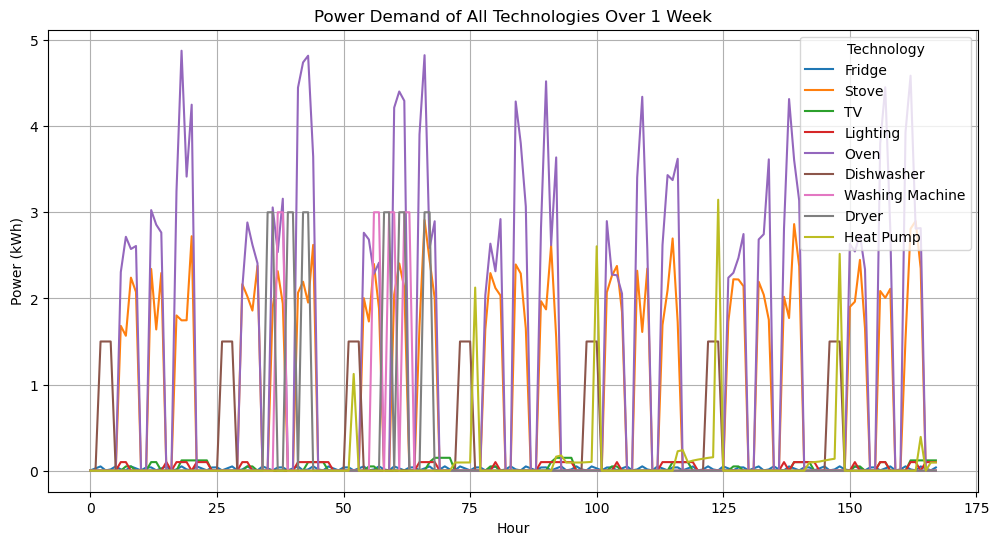

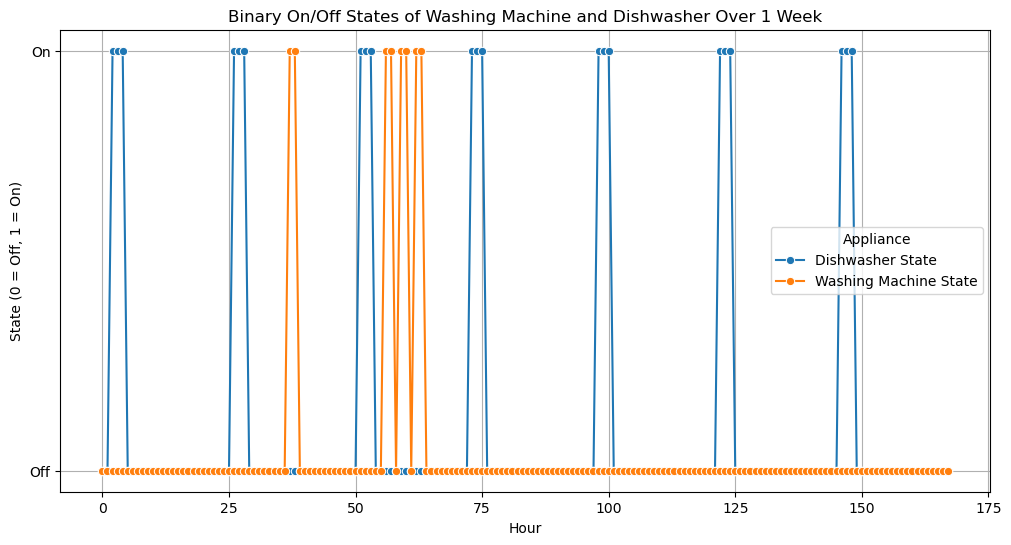

In [21]:
# Define the time range for one week
time_range = range(0, 24 * 7)  # 7 days, 24 hours each

# Create a DataFrame for the first plot
data_power = pd.DataFrame({
    'Hour': list(time_range),
    'Fridge': fridge[:len(time_range)],
    'Stove': stove[:len(time_range)],
    'TV': tv[:len(time_range)],
    'Lighting': lighting[:len(time_range)],
    'Oven': oven[:len(time_range)],
    'Dishwasher': [power_dishwasher * binary_dishwasher[t].X for t in time_range],
    'Washing Machine': [power_wm * binary_wm[t].X for t in time_range],
    'Dryer': [power_dryer * binary_dryer[t].X for t in time_range],
    'Heat Pump': [power_hp[t].X for t in time_range]
})

# Melt the data for easier plotting
data_power_melted = data_power.melt(id_vars='Hour', var_name='Technology', value_name='Power (kWh)')

# Plot 1: Power demand of all technologies
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_power_melted, x='Hour', y='Power (kWh)', hue='Technology')
plt.title('Power Demand of All Technologies Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('Power (kWh)')
plt.legend(title='Technology')
plt.grid(True)
plt.show()

# Create a DataFrame for the second plot
data_binary = pd.DataFrame({
    'Hour': list(time_range),
    'Dishwasher State': [binary_dishwasher[t].X for t in time_range],
    'Washing Machine State': [binary_wm[t].X for t in time_range]
})

# Melt the data for easier plotting
data_binary_melted = data_binary.melt(id_vars='Hour', var_name='Appliance', value_name='State')

# Plot 2: Binary on/off states of washing machine and dishwasher
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_binary_melted, x='Hour', y='State', hue='Appliance', marker='o')
plt.title('Binary On/Off States of Washing Machine and Dishwasher Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('State (0 = Off, 1 = On)')
plt.yticks([0, 1], ['Off', 'On'])
plt.legend(title='Appliance')
plt.grid(True)
plt.show()

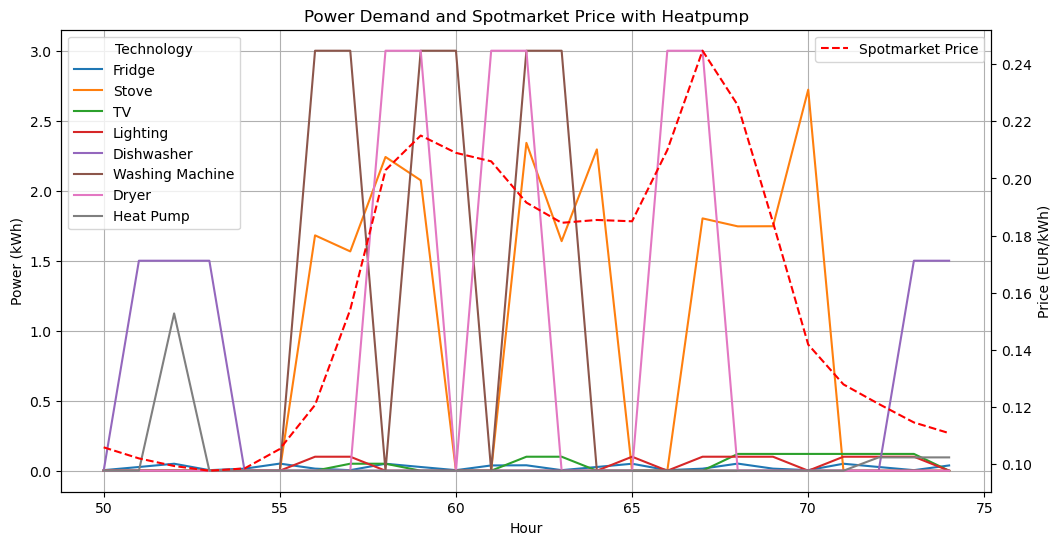

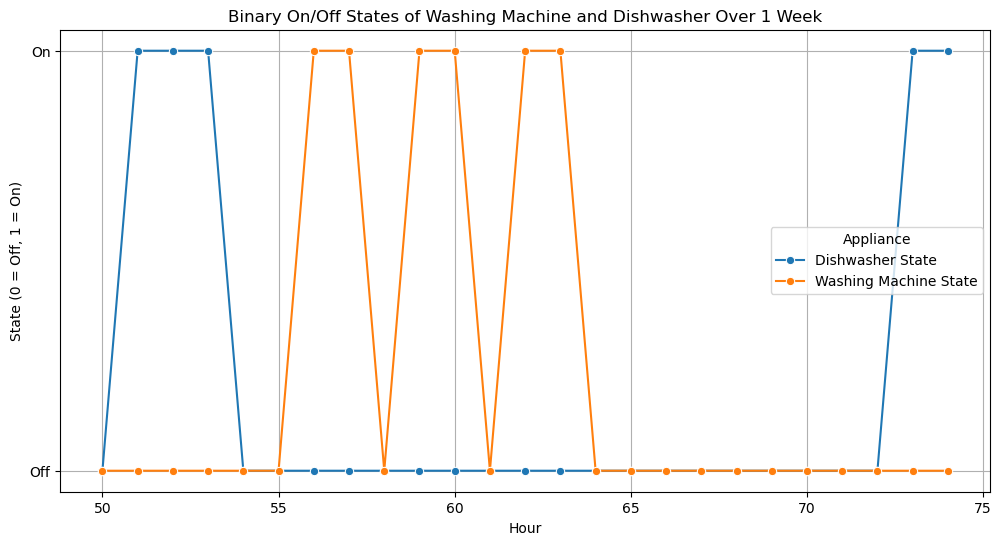

In [22]:
# Define the time range for one week
time_range = range(50,75)  # 7 days, 24 hours each

# Create a DataFrame for the first plot
data_power = pd.DataFrame({
    'Hour': list(time_range),
    'Fridge': fridge[:len(time_range)],
    'Stove': stove[:len(time_range)],
    'TV': tv[:len(time_range)],
    'Lighting': lighting[:len(time_range)],
    'Dishwasher': [power_dishwasher * binary_dishwasher[t].X for t in time_range],
    'Washing Machine': [power_wm * binary_wm[t].X for t in time_range],
    'Dryer': [power_dryer * binary_dryer[t].X for t in time_range],
    'Heat Pump': [power_hp[t].X for t in time_range],
})

# Melt the data for easier plotting
data_power_melted = data_power.melt(id_vars='Hour', var_name='Technology', value_name='Power (kWh)')
total_power = data_power_melted.groupby('Hour')['Power (kWh)'].sum().reset_index()
# Plot 1: Power demand of all technologies
plt.figure(figsize=(12, 6))
ax1 = plt.gca()

# Plot power demand (left y-axis)
sns.lineplot(data=data_power_melted, x='Hour', y='Power (kWh)', hue='Technology', ax=ax1)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Power (kWh)')
ax1.legend(title='Technology', loc='upper left')
ax1.grid(True)

# Create a second y-axis for the binary states
ax2 = ax1.twinx()
sns.lineplot(
    data=pd.DataFrame({'Hour': list(time_range), 'Price': merged_data_winter['Spotmarket_(EUR/kWh)'][:len(time_range)]}),
    x='Hour', y='Price', color='red', label='Spotmarket Price', linestyle='--', ax=ax2
)
ax2.set_ylabel('Price (EUR/kWh)')

plt.title('Power Demand and Spotmarket Price with Heatpump')
plt.show()

# Create a DataFrame for the second plot
data_binary = pd.DataFrame({
    'Hour': list(time_range),
    'Dishwasher State': [binary_dishwasher[t].X for t in time_range],
    'Washing Machine State': [binary_wm[t].X for t in time_range]
})

# Melt the data for easier plotting
data_binary_melted = data_binary.melt(id_vars='Hour', var_name='Appliance', value_name='State')

# Plot 2: Binary on/off states of washing machine and dishwasher
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_binary_melted, x='Hour', y='State', hue='Appliance', marker='o')
plt.title('Binary On/Off States of Washing Machine and Dishwasher Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('State (0 = Off, 1 = On)')
plt.yticks([0, 1], ['Off', 'On'])
plt.legend(title='Appliance')
plt.grid(True)
plt.show()

In [30]:
#lengths of the lists

print("length of pv_summer:", len(pv_summer))
print("length of merged_data_summer:", len(merged_data_summer))
print("length of merged_data_winter:", len(merged_data_winter))
print("length of p_summer:", len(p_summer))
print("length of p_winter:", len(p_winter))
print("length of fridge_summer:", len(fridge_summer))
print("length of fridge_winter:", len(fridge_winter))
print("length of oven_summer:", len(oven_summer))
print("length of oven_winter:", len(oven_winter))
print("length of induction_summer:", len(induction_summer))
print("length of induction_winter:", len(induction_winter))
print("length of tv_summer:", len(tv_summer))
print("length of tv_winter:", len(tv_winter))
print("length of lighting_summer:", len(lighting_summer))
print("length of lighting_winter:", len(lighting_winter))
print("length curtailed:", len(curtail))
print("length unmet:", len(unmet))
print("length of total_load:", len(total_load))
print("length of price:", len(price))
print("length of binary_dishwasher:", len(binary_dishwasher))




length of pv_summer: 672
length of merged_data_summer: 671
length of merged_data_winter: 671
length of p_summer: 672
length of p_winter: 672
length of fridge_summer: 672
length of fridge_winter: 672
length of oven_summer: 672
length of oven_winter: 672
length of induction_summer: 672
length of induction_winter: 672
length of tv_summer: 672
length of tv_winter: 672
length of lighting_summer: 672
length of lighting_winter: 672
length curtailed: 671
length unmet: 671
length of total_load: 671
length of price: 671
length of binary_dishwasher: 671


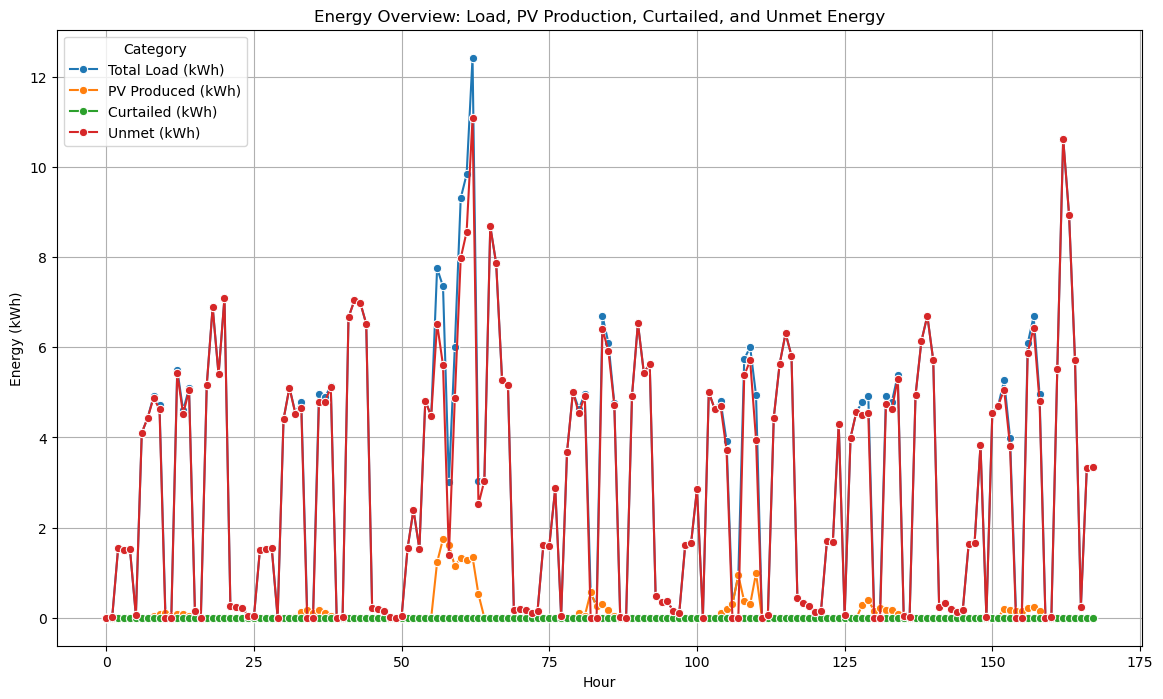

In [ ]:
# Prepare data for plotting
time_range = range(Time_interval)  # Full time range
# Limit the time range to the first two weeks (2 weeks * 7 days * 24 hours = 336 hours)
time_range = range(0, 24 * 7)

data_plot = pd.DataFrame({
    'Hour': list(time_range),
    'Total Load (kWh)': [total_load[t].getValue() for t in time_range],
    'PV Produced (kWh)': pv_winter['PV_energy_production_kWh'].iloc[:24*7].values,
    'Curtailed (kWh)': [curtail[t].X for t in time_range],
    'Unmet (kWh)': [unmet[t].X for t in time_range]
})

# Melt the data for easier plotting
data_plot_melted = data_plot.melt(id_vars='Hour', var_name='Category', value_name='Energy (kWh)')

# Plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=data_plot_melted, x='Hour', y='Energy (kWh)', hue='Category', marker='o')
plt.title('Energy Overview: Load, PV Production, Curtailed, and Unmet Energy')
plt.xlabel('Hour')
plt.ylabel('Energy (kWh)')
plt.legend(title='Category')
plt.grid(True)
plt.show()

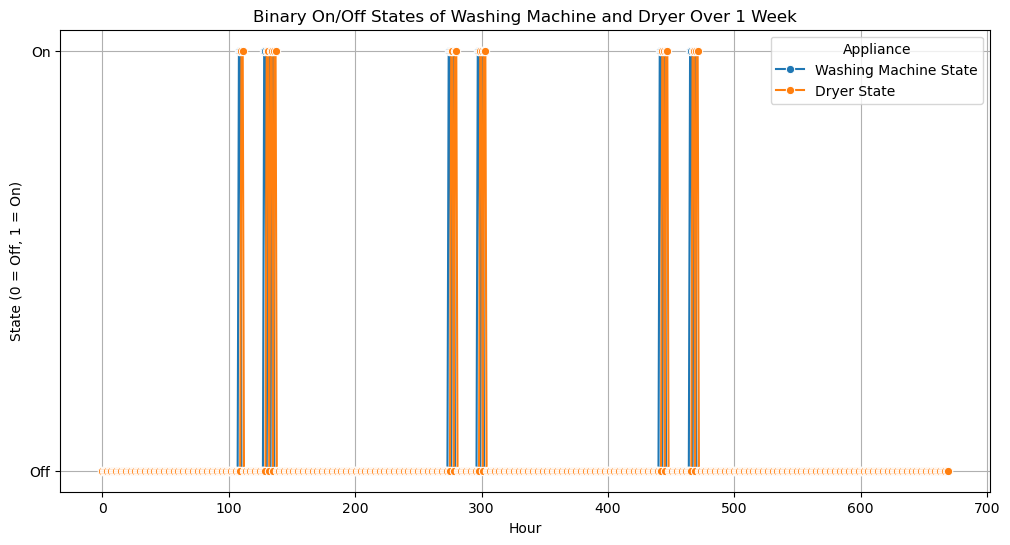

In [80]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# Define the time range for one week (or adjust as needed)
time_range = range(0,670)  # 7 days, 24 hours each

# Prepare DataFrame for binary on/off states
data_binary = pd.DataFrame({
    'Hour': list(time_range),
    'Washing Machine State': [binary_wm[t].X for t in time_range],
    'Dryer State': [binary_dryer[t].X for t in time_range]
})

# Melt for plotting
data_binary_melted = data_binary.melt(id_vars='Hour', var_name='Appliance', value_name='State')

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_binary_melted, x='Hour', y='State', hue='Appliance', marker='o')
plt.title('Binary On/Off States of Washing Machine and Dryer Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('State (0 = Off, 1 = On)')
plt.yticks([0, 1], ['Off', 'On'])
plt.legend(title='Appliance')
plt.grid(True)
plt.show()